# Quantum ML Project - Binary Classification on the Parity problem  |  Task (c)

Install pennylane

In [1]:
# %pip install pennylane
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Data
Data is generated using the parity function. The parity function is a function that returns 1 if the number of 1s in the input is odd, and 0 otherwise. The input is a binary string of length n. The parity function is a well-known example of a function that is not efficiently learnable by a classical neural network. However, it can be learned efficiently by a quantum neural network.

## Read

In [3]:
train_classA = np.loadtxt('./data/classA_train_N5.dat')
train_classB = np.loadtxt('./data/classB_train_N5.dat')
test_classA = np.loadtxt('./data/classA_test_N5.dat')
test_classB = np.loadtxt('./data/classB_test_N5.dat')

train_data = np.vstack((train_classA, train_classB))
train_labels = np.hstack((np.zeros(len(train_classA)), np.ones(len(train_classB))))

In [4]:
X_train = np.vstack((train_classA, train_classB))
Y_train = np.hstack((np.zeros(len(train_classA)), np.ones(len(train_classB))))
X_test = np.vstack((test_classA, test_classB))
Y_test = np.hstack((np.zeros(len(test_classA)), np.ones(len(test_classB))))

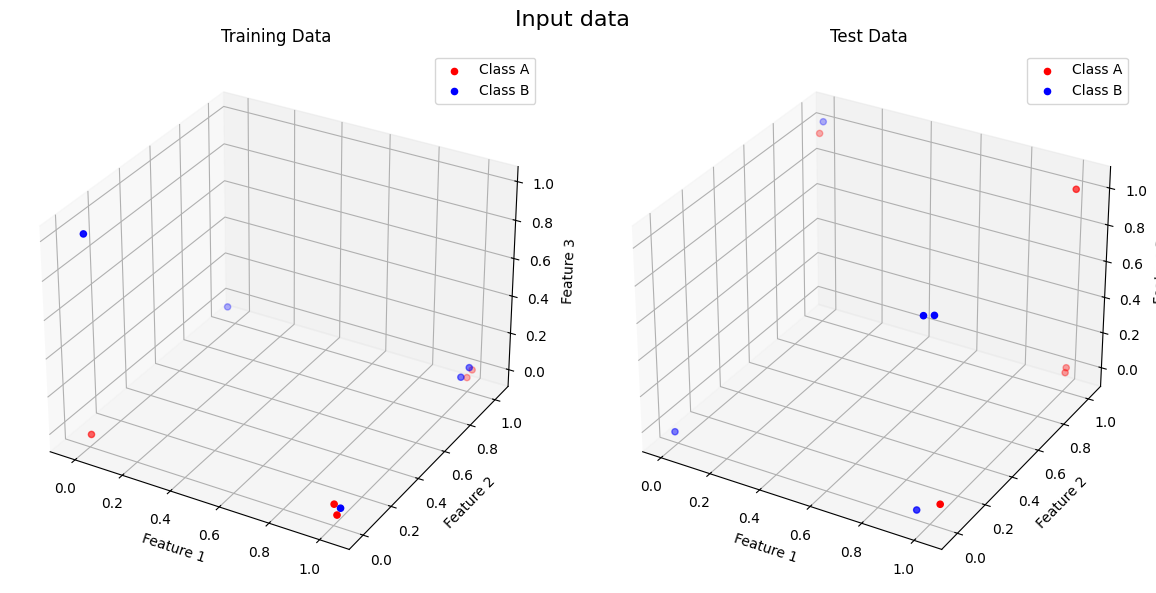

In [16]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(train_classA[0], train_classA[1], train_classA[2], color='red', label='Class A')
ax1.scatter(train_classB[0], train_classB[1], train_classB[2], color='blue', label='Class B')
ax1.set_title('Training Data')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_classA[0], test_classA[1], test_classA[2], color='red', label='Class A')
ax2.scatter(test_classB[0], test_classB[1], test_classB[2], color='blue', label='Class B')
ax2.set_title('Test Data')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')
ax2.legend()

fig.suptitle('Input data', fontsize=16)
plt.tight_layout()
plt.show()

## Data Scaling

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# MSE Loss Function

In [6]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss /= len(labels)
    return loss
n_qubits = train_data.shape[1]

# Quantum Circuit

In [7]:
n_qubits = 5
num_reuploads = 10
dev = qml.device('default.qubit', wires=n_qubits)

## Ansatz architecture

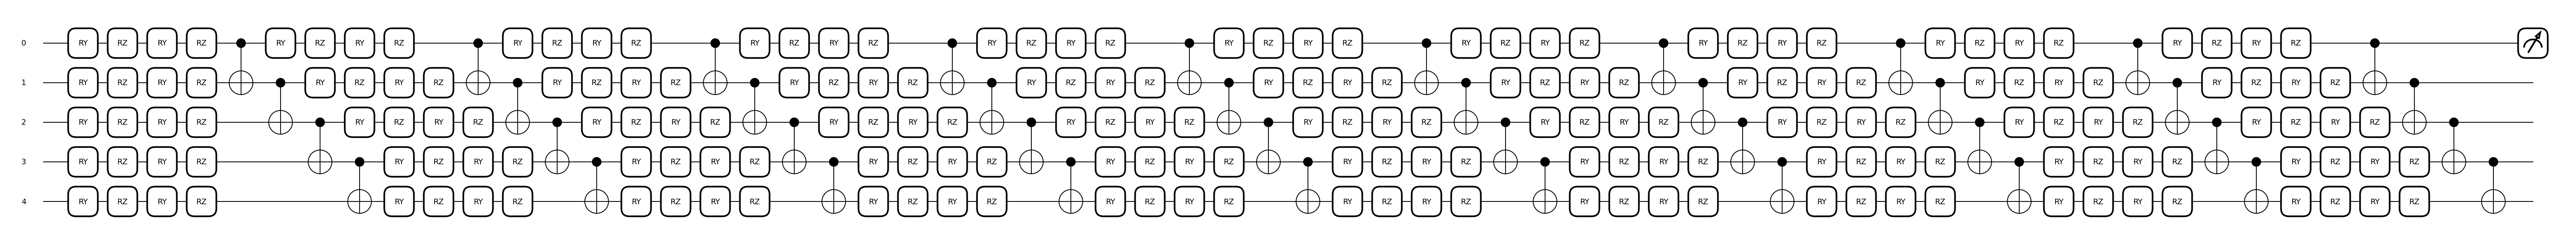

In [8]:
def circuit(weights, x):
    for layer in range(num_reuploads):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
            qml.RZ(weights[layer, i, 0], wires=i)
            qml.RY(weights[layer, i, 1], wires=i)
            qml.RZ(weights[layer, i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))

qnode = qml.QNode(circuit, dev)

weights_init = 0.01 * np.random.randn(num_reuploads, n_qubits, 3)
fig, ax = qml.draw_mpl(circuit)(weights_init, np.zeros(n_qubits))
plt.show()

## Training

In [9]:
def variational_classifier(weights, bias, x):
    return qnode(weights, x) + bias

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

def train(X, Y, num_reuploads, optimizer, learning_rate=0.1, epochs=50, batch_size=5, patience=5):
    np.random.seed(0)
    weights_init = 0.01 * np.random.randn(num_reuploads, n_qubits, 3)
    bias_init = np.array(0.0, requires_grad=True)

    opt = optimizer(learning_rate)
    weights = weights_init
    bias = bias_init

    train_costs = []
    test_accuracies = []
    train_accuracies = []
    captured_states = {}

    best_loss = np.inf
    patience_counter = 0
    for it in range(epochs):
        batch_index = np.random.randint(0, len(X), (batch_size,))
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)
        
        train_predictions = [variational_classifier(weights, bias, x) for x in X]
        train_acc = np.mean((np.array(train_predictions) > 0.5) == Y)
        
        test_predictions = [variational_classifier(weights, bias, x) for x in X_test]
        test_acc = np.mean((np.array(test_predictions) > 0.5) == Y_test)
        
        train_cost = cost(weights, bias, X, Y)
        train_costs.append(train_cost)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        print(f"Iter: {it+1} | Train Cost: {train_cost:.4f} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

        # Early stopping
        if train_cost < best_loss:
            best_loss = train_cost
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return weights, bias, train_costs, train_accuracies, test_accuracies, captured_states


# Evaluation

In [10]:
def evaluate(weights, bias, X, Y):
    predictions = np.array([variational_classifier(weights, bias, x) for x in X])
    accuracy = np.mean((predictions > 0.5) == Y)
    print(f"Accuracy: {accuracy:.4f}")
    return predictions, accuracy

def plot_metrics(iterations, train_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].plot(iterations, train_losses, label='Training Loss')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Iterations vs Training Loss')
    axs[0].legend()

    axs[1].plot(iterations, train_accuracies, label='Training Accuracy', color='orange')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Iterations vs Training Accuracy')
    axs[1].legend()

    axs[2].plot(iterations, test_accuracies, label='Test Accuracy', color='green')
    axs[2].set_xlabel('Iterations')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Iterations vs Test Accuracy')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

def visualize_performance(X, Y, predictions):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    correctly_classified = (predictions > 0.5) == Y
    incorrectly_classified = ~correctly_classified

    ax.scatter(X[correctly_classified, 0], X[correctly_classified, 1], X[correctly_classified, 2], c='green', marker='o', label='Correctly Classified')
    ax.scatter(X[incorrectly_classified, 0], X[incorrectly_classified, 1], X[incorrectly_classified, 2], c='red', marker='x', label='Incorrectly Classified')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title("Data Classification Performance")
    ax.legend()
    plt.show()

In [11]:
epochs = 8
weights, bias, train_costs, train_accuracies, test_accuracies, captured_states = train(train_data, train_labels, num_reuploads, AdamOptimizer, learning_rate=0.1, epochs=epochs, batch_size=5)

Iter: 1 | Train Cost: 0.4874 | Train Accuracy: 0.5312 | Test Accuracy: 0.5667
Iter: 2 | Train Cost: 0.4196 | Train Accuracy: 0.5188 | Test Accuracy: 0.5500
Iter: 3 | Train Cost: 0.3502 | Train Accuracy: 0.5188 | Test Accuracy: 0.5833
Iter: 4 | Train Cost: 0.2935 | Train Accuracy: 0.5813 | Test Accuracy: 0.6000
Iter: 5 | Train Cost: 0.2836 | Train Accuracy: 0.5375 | Test Accuracy: 0.5667
Iter: 6 | Train Cost: 0.2747 | Train Accuracy: 0.4813 | Test Accuracy: 0.6000
Iter: 7 | Train Cost: 0.2672 | Train Accuracy: 0.5250 | Test Accuracy: 0.6500
Iter: 8 | Train Cost: 0.2680 | Train Accuracy: 0.6000 | Test Accuracy: 0.6667


## Accuracy

In [12]:
predictions, accuracy = evaluate(weights, bias, X_test, Y_test)

Accuracy: 0.6667


## Visualize

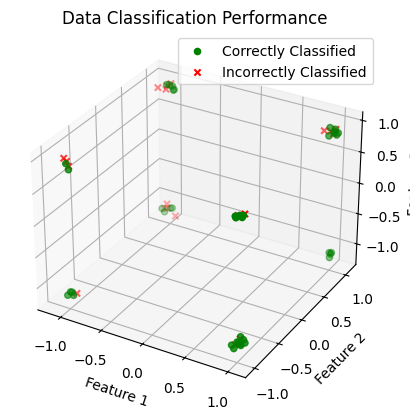

In [13]:
visualize_performance(X_test, Y_test, predictions)

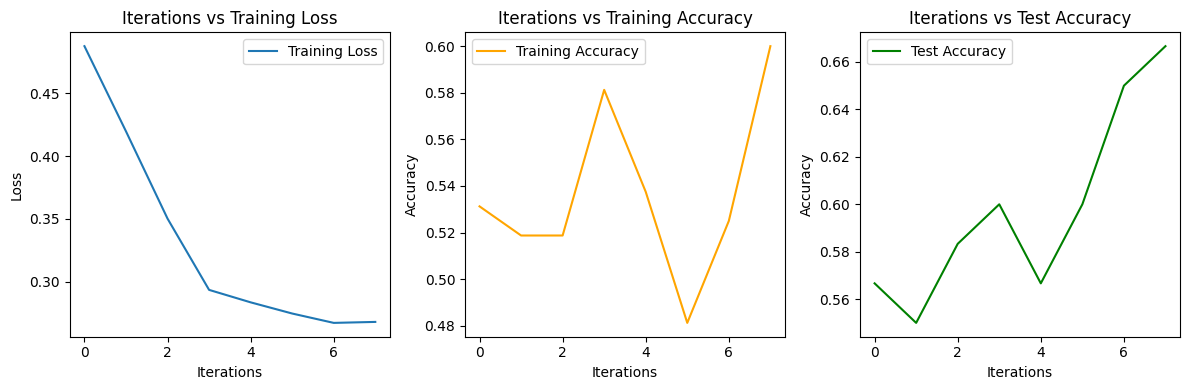

In [14]:
plot_metrics(range(0, epochs), train_costs, train_accuracies, test_accuracies)

## Benchmark with a Classical Neural Network

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, alpha=1e-4, solver='sgd',  tol=1e-4, random_state=1, learning_rate_init=0.1)
clf.fit(X_train, Y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
train_acc = accuracy_score(Y_train, y_pred_train)
test_acc = accuracy_score(Y_test, y_pred_test)
print(f"Classical NN | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

num_params_qnn = num_reuploads * n_qubits * 3 + 1
num_params_nn = np.sum([np.prod(w.shape) for w in clf.coefs_]) + np.sum([np.prod(b.shape) for b in clf.intercepts_])
print(f"Number of parameters | Quantum NN: {num_params_qnn} | Classical NN: {num_params_nn}")

Classical NN | Train Accuracy: 0.9125 | Test Accuracy: 0.9500
Number of parameters | Quantum NN: 151 | Classical NN: 71


c:\Users\nikol\miniconda3\envs\qml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
